##### Copyright 2025 Google LLC.

# Task Orchestration (Temporal Logic & Control Loops)

Robotics applications often involve sequential decision-making and continuous verification. Gemini can act as a high-level orchestrator, breaking down complex tasks into steps or verifying success before proceeding.

This notebook covers:
1.  **Temporal Logic:** Analyzing video data to understand demonstrations.
2.  **Visual Verification:** Using multi-view context to detect success or failure.
3.  **The Perception-Action Cycle:** Generating code to drive a robot API.

## 1. Setup & Initialization

In [ ]:
%pip install -U -q google-genai google-colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [ ]:
import os
import urllib.request
import textwrap
import time
import json
from PIL import Image, ImageSequence

if not os.path.exists('robotics_utils.py'):
    url = "https://raw.githubusercontent.com/williamito/robotics-samples/refs/heads/main/robotics_utils.py"
    urllib.request.urlretrieve(url, 'robotics_utils.py')

import robotics_utils as utils
utils.download_assets()

In [ ]:
from google.colab import userdata
from google import genai
from google.genai import types

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)
MODEL_ID = "gemini-3-flash-preview"

## 2. Part 1: Temporal Logic (Video Analysis)

### Example: Parsing a Human Demonstration
Robots can "Learn from Demonstration" by watching a video and extracting structured steps.

In [ ]:
myfile = client.files.upload(file="desk_organization.mp4")
while myfile.state == "PROCESSING":
    time.sleep(1)
    myfile = client.files.get(name=myfile.name)

prompt = "Describe in detail each step of the task. Breakdown by timestamp in JSON format."
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[myfile, prompt],
    config=types.GenerateContentConfig(response_mime_type="application/json")
    )
print(response.text)

[
  {
    "start": "00:00",
    "end": "00:03",
    "label": "The robotic arm moves toward the green eraser."
  },
  {
    "start": "00:03",
    "end": "00:06",
    "label": "The robotic arm picks up the green eraser and places it in the tray."
  },
  {
    "start": "00:06",
    "end": "00:10",
    "label": "The robotic arm moves toward the red pen."
  },
  {
    "start": "00:10",
    "end": "00:15",
    "label": "The robotic arm moves toward the blue pen."
  },
  {
    "start": "00:15",
    "end": "00:17",
    "label": "The robotic arm picks up the blue pen."
  },
  {
    "start": "00:17",
    "end": "00:20",
    "label": "The robotic arm picks up the red pen."
  },
  {
    "start": "00:20",
    "end": "00:23",
    "label": "The robotic arm places the blue pen into the container."
  },
  {
    "start": "00:23",
    "end": "00:28",
    "label": "The robotic arm places the red pen into the container."
  }
]


### Example: Temporal Pointing (Tracking)
Track objects across frames in a GIF to understand movement.

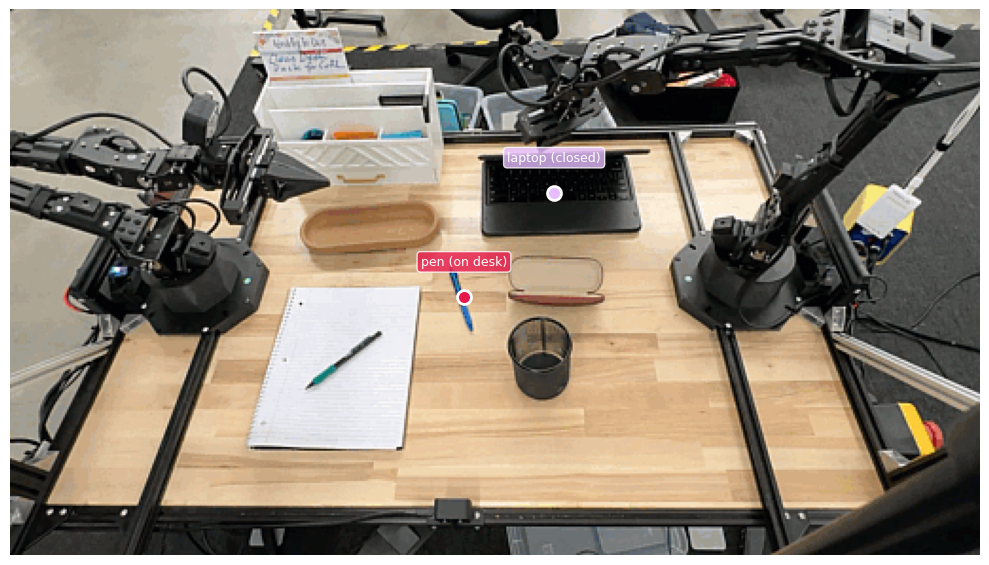

In [ ]:
gif_path = "aloha-pen.gif"
img = Image.open(gif_path)
frames = [frame.copy().convert("RGB") for frame in ImageSequence.Iterator(img)]

# Analyze a single frame (e.g., frame 10)
frame_idx = 10
prompt = "Point to the pen (on desk) and laptop (closed)."
response = utils.query_gemini(client, frames[frame_idx], prompt)
utils.visualize_detections(frames[frame_idx], response)

### Example: Temporal Zoom (Time Range)
Focus analysis on a specific time range within a video.

In [ ]:
prompt_zoom = "Zoom into second 15 to 22 and provide a per-second breakdown of what is happening."

# We use the previously uploaded file 'myfile'
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[myfile, prompt_zoom]
)
print(response.text)

A per-second breakdown of the video from 00:15 to 00:22 is as follows:
- **00:15 - 00:16**: The left robotic arm reaches for the blue pen on the table.
- **00:16 - 00:17**: The left robotic arm secures its grip on the blue pen.
- **00:17 - 00:18**: The left robotic arm lifts the blue pen from the table.
- **00:18 - 00:19**: The left robotic arm begins moving the blue pen toward the black cup.
- **00:19 - 00:20**: The left robotic arm drops the blue pen into the black cup; meanwhile, the right robotic arm moves toward the red pen.
- **00:20 - 00:21**: The right robotic arm grabs and lifts the red pen.
- **00:21 - 00:22**: The right robotic arm places the red pen into the black cup.


## 3. Part 2: Visual Verification (Closed-Loop)

### Example: Multi-View Success Detection
Single camera angles can be misleading. By using multi-view "Before" and "After" images, the model can reliably judge if a task succeeded.

In [ ]:
# Load 4 views of 'Before' and 4 views of 'After'
initial = [Image.open(f"initial_state_{i}.png") for i in range(1, 5)]
current = [Image.open(f"current_state_{i}.png") for i in range(1, 5)]

prompt = """
Comparing the start of the episode (first 4 images) with the current state (last 4 images),
did the robot successfully perform the task 'put the mango into the brown container'?
Answer with (1) yes or (2) no.
"""

response = client.models.generate_content(
    model=MODEL_ID,
    contents=initial + current + [prompt]
)
print(f"Success Result: {response.text}")

Success Result: The robot did not successfully perform the task 'put the mango into the brown container'. While it moved the mango, it placed it into the pink bowl instead of the brown container.

(2) no


## 4. Part 3: Perception-Action Loop

### Example: Generating Robot API Calls
We can define a set of Python functions representing a robot's hardware API and let the model generate the code to drive them.

In [ ]:
# 1. Define the Mock API
def move(x, y, high):
    print(f"[ROBOT] Moving to: {x}, {y} (Height={'High' if high else 'Low'})")

def setGripper(opened):
    print(f"[ROBOT] Gripper: {'OPEN' if opened else 'CLOSED'}")

# 2. Perceive: Find the Block and Bowl
img_robot = Image.open("soarm-block.png")
response = utils.query_gemini(client, img_robot, "Point to the blue block and orange bowl.")
points = json.loads(response)

# Helper to extract point
def get_point(label_fragment, data):
    for item in data:
        if label_fragment in item['label']:
            return item['point']
    return None

block_pt = get_point("blue block", points)
bowl_pt = get_point("orange bowl", points)

if block_pt and bowl_pt:
    # 3. Calculate Relative Coordinates (Robot Math)
    # The model gives us absolute pixels. We need relative coords for the robot arm.
    robot_origin = [300, 500] # [y, x]

    block_rel = [block_pt[0] - robot_origin[0], block_pt[1] - robot_origin[1]]
    bowl_rel = [bowl_pt[0] - robot_origin[0], bowl_pt[1] - robot_origin[1]]

    print(f"Block Relative: {block_rel}, Bowl Relative: {bowl_rel}")

    # 4. Plan & Act
    prompt_api = f"""
    You have functions: move(x, y, high), setGripper(opened).

    Generate a JSON sequence of calls to:
    1. Pick up the blue block at relative coords {block_rel} (use high=False to grab).
    2. Move it to the orange bowl at relative coords {bowl_rel} (use high=True to travel, False to place).
    """
    response_api = utils.query_gemini(client, img_robot, prompt_api)
    print("Generated Plan:")
    print(response_api)
else:
    print("Could not find objects.")

Block Relative: [435, 158], Bowl Relative: [86, -234]
Generated Plan:
[
  {
    "function": "setGripper",
    "args": {
      "opened": true
    }
  },
  {
    "function": "move",
    "args": {
      "x": 435,
      "y": 158,
      "high": false
    }
  },
  {
    "function": "setGripper",
    "args": {
      "opened": false
    }
  },
  {
    "function": "move",
    "args": {
      "x": 435,
      "y": 158,
      "high": true
    }
  },
  {
    "function": "move",
    "args": {
      "x": 86,
      "y": -234,
      "high": true
    }
  },
  {
    "function": "move",
    "args": {
      "x": 86,
      "y": -234,
      "high": false
    }
  },
  {
    "function": "setGripper",
    "args": {
      "opened": true
    }
  }
]


## Summary

In this notebook, you've combined localization, reasoning, and temporal analysis to create higher-level robot behaviors.

**See Also:**
*   **[API Features](./robotics_api_features.ipynb):** Learn about engineering features like JSON mode and latency control.